In [25]:
import os, json
from typing import Literal, TypedDict

from dotenv import load_dotenv
from langgraph.graph import StateGraph, END, START
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

load_dotenv()

True

In [26]:
OPENAI_KEY = os.getenv("OPENAI_API_KEY")
LLM = ChatOpenAI(model="gpt-4o-mini", api_key=OPENAI_KEY, temperature=0.2)

In [27]:
# ── Constants -----------------------------------------------------------------
MAX_MARGIN       = 0.15   # accept if ≤ 15 % below board
MAX_COUNTER_DIFF = 0.30   # counter if ≤ 30 % below board
COUNTER_STEP     = 0.05   # counter = offer +5 % of board
MAX_ATTEMPTS     = 3

# ── State schema --------------------------------------------------------------
class NegotiationState(TypedDict, total=False):
    board_rate: int
    offer: float
    attempts: int
    result: dict    # {"status": str, "target_rate": float, "message": str}

In [28]:
system_prompt = """
    You are “AcmeBot,” a senior freight broker tasked with negotiating
    spot-market rates with carrier drivers.
    Respond ONLY with valid JSON (no extra text) containing the keys
    `status`, `target_rate`, and `message`.

    Context
    • Board (posted) rate ...............  {board_rate}
    • Driver’s current offer ............  {offer}
    • You may make at most three counter-rounds in total.
    • All money values are whole US dollars (no cents).

    Decision rules
    1. **Accept**  – If the driver’s offer is ≤ 15 % below the board rate.
    2. **Counter** – If the driver’s offer is > 15 % and ≤ 30 % below the board
       rate.  Your counter must be `offer + (5 % × board_rate)`, rounded to the
       nearest dollar.
    3. **Reject**  – If the driver’s offer is > 30 % below the board rate OR if
       this round would exceed the 3-round limit.
    Return STRICT JSON only.
"""

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "Board rate is: ${board_rate}\nCurrent offer: ${offer}"),
    ]
)

In [29]:
def llm_init(board_rate:int,offer:float) -> dict:
    """
    Ask the LLM to evaluate one negotiation round and return a JSON dict
    with status / target_rate / message.
    """
    # render messages from the template
    msgs = prompt.format_messages(board_rate=board_rate, offer=offer)

    resp = LLM.invoke(msgs)          

    # extract text
    text = resp.content if hasattr(resp, "content") else str(resp)

    try:
        return json.loads(text)
    except Exception as exc:
        raise ValueError(f"LLM returned non-JSON: {text!r}") from exc

In [30]:
def decide_round(board_rate: int, offer: float, tries: int) -> dict:
    diff = (board_rate - offer) / board_rate
    # Accept ------------------------------------------------------------------
    if diff <= MAX_MARGIN:
        return {
            "status": "accept",
            "target_rate": offer,
            "message": f"Understood. We can confirm at **${offer:,.0f}** and book the load."
        }

    # Counter -----------------------------------------------------------------
    if diff <= MAX_COUNTER_DIFF and tries < MAX_ATTEMPTS:
        tgt = offer + board_rate * COUNTER_STEP
        return {
            "status": "counter",
            "target_rate": round(tgt, 2),
            "message": (
                f"I can meet you at **${tgt:,.0f}** on this lane. "
                "Would that be acceptable?"
            ),
        }

    # Reject ------------------------------------------------------------------
    return {
        "status": "reject",
        "target_rate": board_rate,
        "message": (
            "I’m afraid we’re too far apart on rate for this load. "
            "Let’s reconnect on another opportunity."
        ),
    }

In [31]:
def evaluate(state: NegotiationState) -> NegotiationState:
    """Graph node: run one negotiation evaluation."""
    board_rate, offer, tries = state["board_rate"], state["offer"], state["attempts"]

    result = llm_init(board_rate, offer)
    if not result:
        result = decide_round(board_rate, offer, tries)

    next_state = state.copy()
    next_state["result"] = result

    if result["status"] == "counter":
        next_state["offer"]    = result["target_rate"]
        next_state["attempts"] = tries + 1

    return next_state

In [32]:
def router(state: NegotiationState) -> Literal["accept","reject","counter"]:
    status   = state["result"]["status"]
    attempts = state["attempts"]
    if status == "counter" and attempts > MAX_ATTEMPTS:
        return "reject"
    return status

In [33]:
wf = StateGraph(NegotiationState, name="AgenticNegotiation")

wf.add_node("Evaluate", evaluate)
wf.add_edge(START, "Evaluate")

wf.add_conditional_edges("Evaluate", router,
                         {"accept": END, "reject": END, "counter": "Evaluate"})

GRAPH = wf.compile()

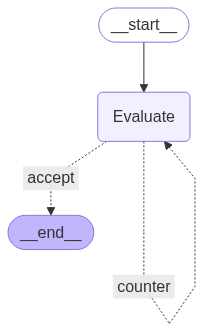

In [34]:
GRAPH

In [35]:
# ── Public helper -------------------------------------------------------------
def run_negotiation(board_rate: int, initial_offer: float, attempts: int = 1) -> dict:
    """
    Args:
        board_rate    – Load board rate
        initial_offer – Carrier’s first offer
        attempts      – Current attempt count (1-based)

    Returns JSON dict with keys: status, target_rate, message
    """
    init: NegotiationState = {
        "board_rate": board_rate,
        "offer":      initial_offer,
        "attempts":   attempts,
    }
    final = GRAPH.invoke(init)
    return final["result"]

In [36]:
tests = [
    (2300, 2400, 1),   # already above board → accept
    (2300, 2000, 1),   # 13 % below board → accept
    (2300, 1800, 1),   # 22 % below board → counter
    (2300, 1500, 1),   # 35 % below board → reject
]

for board, offer, tries in tests:
    out = run_negotiation(board, offer, tries)
    print(f"board={board}  offer={offer} → {out}")


board=2300  offer=2400 → {'status': 'accept', 'target_rate': 2400, 'message': 'We accept your offer of $2400.'}
board=2300  offer=2000 → {'status': 'accept', 'target_rate': 2150, 'message': "Accepted the driver's offer."}
board=2300  offer=1800 → {'status': 'counter', 'target_rate': 2150, 'message': 'I can offer you $2150.'}
board=2300  offer=1500 → {'status': 'reject', 'target_rate': None, 'message': "The driver's offer is more than 30% below the board rate."}


In [71]:
import os, requests, pprint
url = "https://mobile.fmcsa.dot.gov/qc/services/carriers/docket-number/109533"
r = requests.get(url, params={"webKey": WEBKEY}, timeout=10)
data = r.json()                            # could be dict, list, or []
status = r.status_code

print("HTTP:", status)
pprint.pp(data) 

HTTP: 200
{'content': [{'_links': {'basics': {'href': 'https://mobile.fmcsa.dot.gov/qc/services/carriers/121058/basics'},
                         'cargo carried': {'href': 'https://mobile.fmcsa.dot.gov/qc/services/carriers/121058/cargo-carried'},
                         'operation classification': {'href': 'https://mobile.fmcsa.dot.gov/qc/services/carriers/121058/operation-classification'},
                         'docket numbers': {'href': 'https://mobile.fmcsa.dot.gov/qc/services/carriers/121058/docket-numbers'},
                         'carrier active-For-hire authority': {'href': 'https://mobile.fmcsa.dot.gov/qc/services/carriers/121058/authority'}},
              'carrier': {'allowedToOperate': 'Y',
                          'bipdInsuranceOnFile': '5000',
                          'bipdInsuranceRequired': 'Y',
                          'bipdRequiredAmount': '5000',
                          'bondInsuranceOnFile': '75',
                          'bondInsuranceRequired': 'Y',
  

# Testing FMCSA Authentication

In [79]:
import re, requests, os
from dotenv import load_dotenv
load_dotenv()
WEBKEY = os.getenv("FMCSA_WEBKEY")

BASE = "https://mobile.fmcsa.dot.gov/qc/services"
TIMEOUT = 10

def verify_mc(mc_number: str | int, webkey: str) -> dict:
    mc_number = re.sub(r"\D", "", str(mc_number))        # strip “MC-”
    url = f"{BASE}/carriers/docket-number/{mc_number}"
    data = requests.get(url, params={"webKey": webkey}, timeout=TIMEOUT).json()

    # --- normalise carrier object regardless of wrapper -----------------
    if isinstance(data, list):                      # name search
        carrier = data[0] if data else None
    elif isinstance(data, dict):
        if "content" in data and data["content"]:
            carrier = data["content"][0].get("carrier")
        else:                                       # /carriers/<dot>
            carrier = data.get("carrier")
    else:
        carrier = None

    if carrier:
        return {
            "eligible": True,
            "mc": mc_number,
            "dot": carrier.get("dotNumber"),
            "name": carrier.get("legalName"),
            "state": carrier.get("phyState"),
        }

    # fall-back – empty list or explicit error block
    return {
        "eligible": False,
        "mc": mc_number,
        "status": data.get("errorMessage", "NOT_FOUND")
        if isinstance(data, dict) else "NOT_FOUND",
    }

for mc in ("121805", "109533", "166960", "133655"):
    print(verify_mc(mc, WEBKEY))


{'eligible': True, 'mc': '121805', 'dot': 239039, 'name': 'FEDEX FREIGHT INC', 'state': 'AR'}
{'eligible': True, 'mc': '109533', 'dot': 121058, 'name': 'TFORCE FREIGHT INC', 'state': 'VA'}
{'eligible': True, 'mc': '166960', 'dot': 241572, 'name': 'LANDSTAR RANGER INC', 'state': 'FL'}
{'eligible': True, 'mc': '133655', 'dot': 264184, 'name': 'SCHNEIDER NATIONAL CARRIERS INC', 'state': 'WI'}


In [78]:
import os, re
import requests
from dotenv import load_dotenv
load_dotenv()
WEBKEY = os.getenv("FMCSA_WEBKEY")

def verify_mc(mc_number: str | int,
              webkey: str,
              timeout: int = 10) -> dict:
    """
    Look up an MC docket number via FMCSA QCMobile and return a
    compact status block.

    Returns
    -------
    dict with keys:
        mc_number     str   – digits only
        eligible      bool  – True if carrier record found
        status        str   – 'SUCCESS', 'NOT_FOUND', or API error message
        carrier_name  str|None
    """
    # 1. sanitise MC -> digits only
    mc_number = re.sub(r"\D", "", str(mc_number))
    url = f"https://mobile.fmcsa.dot.gov/qc/services/carriers/docket-number/{mc_number}"

    try:
        resp  = requests.get(url,
                             params={"webKey": webkey},
                             timeout=timeout)
        data  = resp.json()          # may be list, dict, or []
    except Exception as exc:         # network or JSON error
        return {
            "mc_number": mc_number,
            "eligible":  False,
            "status":    f"REQUEST_ERROR: {exc}",
            "carrier_name": None,
        }

    # 2. locate the carrier block regardless of wrapper
    carrier = None
    if isinstance(data, list) and data:
        carrier = data[0]
    elif isinstance(data, dict):
        if "content" in data and data["content"]:
            carrier = data["content"][0].get("carrier") \
                      or data["content"][0]
        elif "carrier" in data:
            carrier = data["carrier"]

    # 3. build return payload
    if carrier:
        name = (carrier.get("legalName")
                or carrier.get("dbaName")
                or carrier.get("entityName"))
        return {
            "mc_number": mc_number,
            "eligible":  True,
            "status":    "SUCCESS",
            "carrier_name": name,
        }

    # fall-back: empty list or explicit error dict
    status_msg = ("NOT_FOUND"
                  if not isinstance(data, dict)
                  else data.get("errorMessage", "NOT_FOUND"))
    return {
        "mc_number": mc_number,
        "eligible":  False,
        "status":    status_msg,
        "carrier_name": None,
    }


verify_mc("121805", WEBKEY)  # example call

{'mc_number': '121805',
 'eligible': True,
 'status': 'SUCCESS',
 'carrier_name': 'FEDEX FREIGHT INC'}